- To download this notebook, click the download icon in the toolbar above and select the .ipynb format.  
- For any questions or comments, please open an issue on the [c4dynamics issues page](https://github.com/C4dynamics/C4dynamics/issues).  

# Vehicle Steering Control Using MPC

This notebook implements a **Model Predictive Controller (MPC)** for vehicle steering using the [c4dynamics](https://github.com/c4dynamics/c4dynamics) library.

**Goal:** Control the lateral position **(y)** and heading angle **(ψ)** of a vehicle to track a straight line using steering input **(δ)**.


## Import Required Libraries

In [212]:
import numpy as np
import cvxpy as cp
import c4dynamics as c4d
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## System Model

We consider a simplified kinematic model of a vehicle with 2 states `[ψ ; y]` `[1]`:

$
\dot{\psi}(t) = \delta(t)
$

$
\dot{y}(t) = V \psi(t)
$

where:  
- `y` = lateral position [m]  
- `ψ` = heading angle [rad]  
- `V` = vehicle velocity [m/s]  
- `δ` = steering input [rad/s]


### System and Simulation Parameters

Define vehicle speed, initial states, simulation step, and duration.

In [213]:
V = 10  # vehicle speed [m/s]

# Initial states
psi0 = 0  # heading angle [rad]
y0 = 1    # lateral position [m]

dt = 0.1   # time step [s]
t_end = 8  # simulation end time [s]

### Vehicle Model Function

In [214]:
def vehicle_model(t, x, delta, V=V):
    psi, y = x
    return [delta, V * psi]

## Initialize Vehicle State

Use `c4dynamics.state` to store vehicle states over time.


In [215]:
vehicle = c4d.state(psi=psi0, y=y0)

## Model Predictive Controller (MPC)
The vehicle steering is controlled using a Model Predictive Controller. The MPC computes the optimal steering input `δ` over a finite prediction horizon to regulate both the lateral position `y` and heading angle `ψ` of the vehicle.

### MPC parameters

- Prediction horizon `N`  
- State weighting `Q`  
- Input weighting `R`  
- Maximum steering input `u_max`

In [216]:
N = 5  # prediction horizon
Q = np.diag([50.0, 50.0])   # weight on [psi, y]
R = np.array([[10]])    # weight on delta
u_max = 0.2             # max steering rate [rad/s]

### Discrete Vehicle Model

Continuous-time kinematic model:

$
\dot{\psi}(t) = \delta(t), \quad \dot{y}(t) = V \psi(t)
$

is discretized with timestep `dt = 0.1 s`:

$
\psi_{k+1} = \psi_k + \delta_k \ dt
$

$
y_{k+1} = y_k + V \psi_k \ dt + 0.5 V \ dt^2 \ \delta_k
$


In [217]:
A_d = np.array([
    [1.0, 0.0],
    [V * dt, 1.0]
])

B_d = np.array([
    [dt],
    [0.5 * V * dt**2]
])

### MPC Problem Formulation

- Prediction horizon: `N` steps  
- Quadratic cost function:

$
J = \sum_{k=0}^{N-1} \left( x_k^\top Q x_k + u_k^\top R u_k \right) + x_N^\top Q x_N
$

- Steering constraints: $|\delta| \le 0.2 \text{ rad/s}$

In [218]:
def solve_mpc(current_x):
    x = cp.Variable((2, N + 1))
    u = cp.Variable((1, N))
    cost = 0
    constraints = [x[:, 0] == current_x]

    for k in range(N):
        cost += cp.quad_form(x[:, k], Q) + cp.quad_form(u[:, k], R)
        constraints += [
            x[:, k+1] == A_d @ x[:, k] + B_d @ u[:, k],
            cp.abs(u[:, k]) <= u_max
        ]

    cost += cp.quad_form(x[:, N], Q)
    cp.Problem(cp.Minimize(cost), constraints).solve(solver=cp.OSQP)

    return u.value[0, 0]

## Simulation

At each time step:  

1. Measure current state  
2. Solve MPC for optimal steering input  
3. Apply input using `solve_ivp`  
4. Store state for plotting

In [219]:
delta_hist = []
time_hist = []

for ti in np.arange(0, t_end, dt):
    delta = solve_mpc(vehicle.X)
    sol = solve_ivp(vehicle_model, [ti, ti + dt], vehicle.X, args=(delta,))
    vehicle.X = sol.y[:, -1]
    vehicle.store(ti)
    delta_hist.append(delta)
    time_hist.append(ti)

## Results

- **Lateral position (`y`)** moves from the initial offset toward zero.  
- **Heading angle (`ψ`)** adjusts transiently to correct lateral error.  
- **Steering input (`δ`)** applies a bounded corrective action and settles near zero once stabilized.

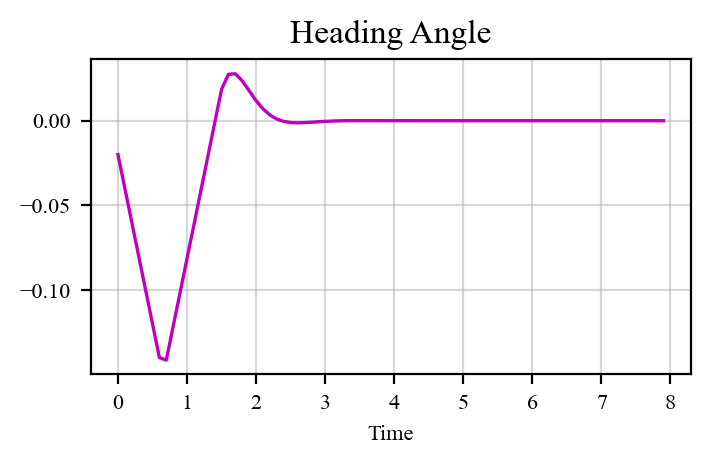

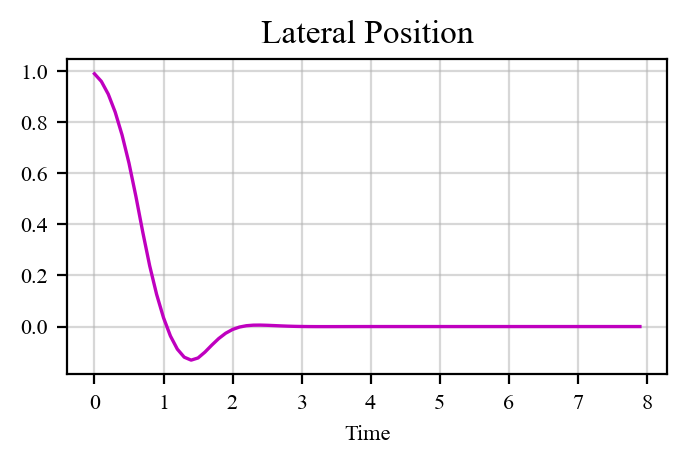

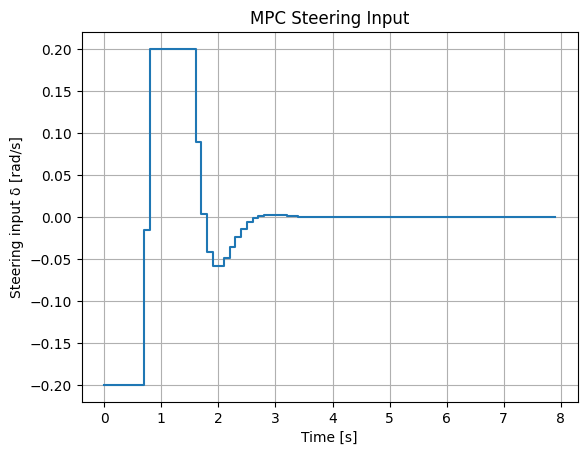

In [220]:
# Heading angle
vehicle.plot('psi', darkmode=False)
plt.title('Heading Angle')

# Lateral position
vehicle.plot('y', darkmode=False)
plt.title('Lateral Position')

# Steering input
plt.figure(3)
plt.step(time_hist, delta_hist, where='post')
plt.xlabel('Time [s]')
plt.ylabel('Steering input δ [rad/s]')
plt.title('MPC Steering Input')
plt.grid(True)
plt.show()

## References

[1] J. B. Rawlings and D. Q. Mayne, *Model Predictive Control: Theory, Computation, and Design*, 1st ed. Nob Hill Publishing, 2009. Lecture notes: Stanford EE392M, Lecture 14: Model Predictive Control. [Online]. Available: https://web.stanford.edu/class/archive/ee/ee392m/ee392m.1056/Lecture14_MPC.pdf

# Appendix 
## Complete Linearization of a Planar Kinematic Model

In [System Model](#system-model) we presented the final form of the linear simplified representation of the system.  


The steps for a formal linearization:  

1. Write the nonlinear model
2. Choose an operating point
3. Define perturbation variables 
4. Compute Jacobians
5. Expand first-order Taylor series
6. Form the linear state-space model 
7. Validate the linearization

In this appendix we go step by step to linearize the planar kinematic of a vehicle about a straight-line reference trajectory. 

## 1. Nonlinear Continuous-Time Model

We consider a point mass moving in the plane with constant speed ($V$) and heading angle ($\psi$).  
The control input is the heading rate.
To avoid confusion with the approximation operator $\delta$, we use $u$ as the control input along the appendix. 

Precise nonlinear equations: 

$$
\begin{aligned}
\dot{x} = V \cdot \cos\psi \\
\dot{y} = V \cdot \sin\psi \\
\dot{\psi} = u
\end{aligned}
$$

where:  
- $x$: longitudinal position [m]
- $y$: lateral position [m]  
- $V$: vehicle velocity [m/s]  
- $ψ$: heading angle [rad]  
- $u$: steering input [rad/s]

State vector:  

$$
X = \begin{bmatrix} 
x & y & \psi 
\end{bmatrix}^T
$$


To linearize the system we have to define a reference trajectory, or operating point, about which the system is approximated. 

---


## 2. Reference Trajectory (Operating Point)

We linearize the system about a **straight-line motion** with constant heading ($\psi_r$) and zero control input.


$$
\begin{aligned}
\psi_r &= \text{const.} \\
u_r &= 0
\end{aligned}
$$

The corresponding reference trajectory $X_r$ is:


$$
\begin{aligned}
x_r(t) = V \cdot \cos\psi_r \cdot t \\
y_r(t) = V \cdot \sin\psi_r \cdot t \\
\psi_r(t) = \psi_r
\end{aligned}
$$


### Time Derivative of the Reference Trajectory

Differentiation of the reference trajectory gives: 
$$
\dot{X}_r =
\begin{bmatrix}
V \cdot \cos\psi_r \\
V \cdot \sin\psi_r \\
0
\end{bmatrix}
$$



### Consistency Check

Substituting $(\mathbf{X}_r, u_r)$ into the nonlinear model gives:


$$
\begin{aligned}
\dot{x} &= V \cdot \cos\psi_r \\
\dot{y} &= V \cdot \sin\psi_r \\
\dot{\psi} &= 0
\end{aligned}
$$

which matches $\dot{X}_r$.  
Thus, the reference is dynamically consistent.


The complete trajectory is therefore a construction of a straight line and a deviations part. 

Deviations from this reference trajectory can now be approximated by the linear parts of a Taylor series. 

---


## 3. Perturbation Variables

Define deviations $\delta{X}, \delta{u}$ from the reference trajectory:

$$
\begin{aligned}
\delta{X} = X - X_r  \\
\delta{u} = u - u_r  
\end{aligned}
$$

With time derivative:

$$
\dot{X} = \dot{X}_r + \delta \dot{X}
$$

These nonlinear deviations can be approximated by the first-order terms with in the Taylor expansion with respect to the state and the input deviations. 


![linearization](linearization.png)
---


## 4. First-Order Taylor Expansion

Let: 
$$
\dot{X} = f(X, u)
$$

A first-order Taylor expansion about $(X_r, u_r)$ yields (higher order terms are neglected): 

$$
\begin{aligned}

\dot{X} = \dot{X}_r + \delta \dot{X} \approx f(X_r, u_r)

+ \left.\frac{\partial f}{\partial X}\right|_{r} \cdot \Delta X
+ \left.\frac{\partial f}{\partial u}\right|_{r} \cdot \Delta u

\end{aligned}
$$

Since
$$
\dot{X}_r = f(X_r, u_r)
$$

the perturbation dynamics are

$$
\Delta \dot{X} = A \cdot \Delta X + B \cdot \Delta u
$$

Where:

- $\Delta \dot{X} \approx \delta \dot{X}$
- $A = \left.\frac{\partial f}{\partial X}\right|_{r}$  
- $B = \left.\frac{\partial f}{\partial u}\right|_{r}$

---


## 5. Jacobian Computation

$A$ and $B$ are given by the Jacobians, i.e., the partial derivatives of $f$ with respect to the state $X$ and with respect to the input $u$. 

### Jacobian with Respect to the State

$$
A = \left.\frac{\partial f}{\partial X}\right|_{X_r, u_r}
$$

Partial derivatives:

$$
\begin{aligned}

\frac{\partial \dot{x}} {\partial x}      = 0, &
\frac{\partial \dot{x}} {\partial y}      = 0, &
\frac{\partial \dot{x}} {\partial \psi} = -V \cdot \sin\psi_r \\

\frac{\partial \dot{y}} {\partial x}      = 0, &
\frac{\partial \dot{y}} {\partial y}      = 0, &
\frac{\partial \dot{y}} {\partial \psi} = V \cdot \cos\psi_r \\

\frac{\partial \dot{\psi}} {\partial x} = 0, &
\frac{\partial \dot{\psi}} {\partial y} = 0, &
\frac{\partial \dot{\psi}} {\partial \psi} = 0

\end{aligned}
$$

Thus

$$
A =
\begin{bmatrix}
0 & 0 & -V \cdot \sin\psi_r \\
0 & 0 &  V \cdot \cos\psi_r \\
0 & 0 & 0
\end{bmatrix}
$$



### Jacobian with Respect to the Input

$$
B = \left.\frac{\partial f}{\partial u}\right|_{X_r, u_r}
= \begin{bmatrix}
0 \\
0 \\
1
\end{bmatrix}
$$

---


## 6. Linearized Continuous-Time System

Substitution of the coefficients of $A$ and $B$ into the equation representation of the system: 

$$
\begin{aligned}
\Delta \dot{x} = -V \cdot \sin\psi_r \cdot \Delta \psi \\
\Delta \dot{y} =  V \cdot \cos\psi_r \cdot \Delta \psi \\
\Delta \dot{\psi} = \Delta u
\end{aligned}
$$

Recall that $\delta{X}$ represents the true nonlinear deviation, while $\Delta{X}$ denotes its first-order approximation used by the linear model.  
The physical interpretation of the coefficients in the linearized equations is as follows:  
- At first order, position deviations are caused only by heading perturbations. Velocity components aligned with the reference trajectory affect position only through higher-order terms.
- The tangent component (along the reference velocity) contributes only at second order, so it does not appear in the linearized $(\delta x, \delta y)$ equations.  
- The term $-V \cdot \sin\psi_r$ is the $x$-component of the normal component of the velocity deviation.  
- The term $V \cdot \cos\psi_r$ is the $y$-component of the normal component of the velocity deviation.


Define:

$$
\begin{aligned}
V_x = -V \cdot \sin\psi_r \\
V_y =  V \cdot \cos\psi_r
\end{aligned}
$$

Then:

$$
\begin{aligned}
\Delta \dot{x} = V_x \cdot \Delta \psi \\
\Delta \dot{y} = V_y \cdot \Delta \psi \\
\Delta \dot{\psi} = \Delta u
\end{aligned}
$$

This is the final linearized form of the a planar kinematic of a vehicle about a straight-line reference trajectory.  

### Notation Modification 

From this point onward, we redefine the perturbation variables $(\Delta{x} \rightarrow x,\Delta{y} \rightarrow y,\Delta{\psi} \rightarrow \psi)$ as the system state for notational simplicity.
Or simply: 

$$
\begin{aligned}
\dot{x} = V_x \cdot \psi \\
\dot{y} = V_y \cdot \psi \\
\dot{\psi} = u
\end{aligned}
$$


---


## 7. Zero-Heading Reference Simplification 

Now, let's assume the reference trajectory is parallel to the $x$ axis, i.e. $\psi_r = 0$.  

The linear model simplifies to:  

$$
\begin{aligned}
V_x = -V \cdot \sin 0 = 0 \\
V_y =  V \cdot \cos 0 = V  \\
\end{aligned}
$$

That is:

$$
\begin{aligned}
\dot{x} = 0 \\
\dot{y} = V \cdot \psi \\
\dot{\psi} = u
\end{aligned}
$$


Under this assumption the perturbation dynamics is as follows: 
- No motion in $x$ ($\dot{x} = 0$)
- The velocity in $y$ is simply the velocity angle ($\psi$) scaled by the velocity magnitude ($V$) 

Since the perturbation in $x$ is identically zero for a straight reference aligned with the $x$-axis, the $x$-state can be omitted from the perturbation dynamics without loss of information:

$$
\begin{aligned}
\dot{y} = V \cdot \psi \\
\dot{\psi} = u
\end{aligned}
$$

This simplified perturbation system is used by the MPC optimizer to minimize deviations from the reference trajectory.  
However, for simulation of the vehicle dynamics, the complete state must be reconstructed as:

$$
\begin{aligned}
X = X_r + \Delta{X}
\end{aligned}
$$

Where $X_r$ is the reference dynamics: 


$$
\begin{aligned}
x_r(t) = V \cdot t  \\
y_r(t) = 0          \\
\psi_r(t) = 0
\end{aligned}
$$


And $\Delta{X}$ is the solution of the linearized dynamics. 

--- 


## 8. Discrete-Time Linear Model

Let's discretize the reference model and linearized model using forward Euler discretization with time-step ($dt$):

$$ 
\Delta X_{k+1} = (I + A \cdot dt) \cdot \Delta X_k + B \cdot dt \cdot \Delta u_k = F \cdot \Delta X_k + G \cdot \Delta u_k = 
$$


### Discrete-Time Linearized Model 


$$
F =
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 &  V \cdot dt \\
0 & 0 & 1
\end{bmatrix},
\quad
G =
\begin{bmatrix}
0 \\
0 \\
dt
\end{bmatrix}
$$

For input $u$. 

### Discrete-Time Reference Model


$$
F_r =
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix},
\quad
G_r =
\begin{bmatrix}
V \cdot dt \\
0 \\
0
\end{bmatrix}
$$

Where the reference input corresponds to constant forward velocity. 


---